In [1]:
from transformers import ReformerConfig, ReformerTokenizer, ReformerModel
import sentencepiece as spm

In [2]:
MODEL_MAX_LENGTH = 4608

In [3]:
!mkdir protein_reformer
!echo ARNDCQEGHILKMFPSTWYVOUBZX > "protein_reformer/training_vocab.txt"
spm.SentencePieceTrainer.Train("--input=protein_reformer/training_vocab.txt --model_prefix=spiece --vocab_size=30 --pad_id=29 --character_coverage=1.0")
!mv spiece.model spiece.vocab protein_reformer

tokenizer = ReformerTokenizer(vocab_file="protein_reformer/spiece.model", do_lower_case=True, model_max_length=MODEL_MAX_LENGTH)
tokenizer.save_pretrained("protein_reformer")

A subdirectory or file protein_reformer already exists.


('protein_reformer\\spiece.model',
 'protein_reformer\\special_tokens_map.json',
 'protein_reformer\\added_tokens.json')

In [4]:
configuration = ReformerConfig.from_pretrained("google/reformer-crime-and-punishment")
configuration.axial_pos_shape = (64, 72)
configuration.max_position_embeddings=MODEL_MAX_LENGTH
configuration.vocab_size=tokenizer.vocab_size

configuration.pad_token_id=tokenizer.pad_token_id

# configuration.attn_layers = ["local","lsh","local","lsh"]
configuration.output_hidden_states=True

configuration.save_pretrained('protein_reformer/')

In [3]:
from transformers import ReformerConfig, ReformerTokenizer, ReformerModel
import sentencepiece as spm
MODEL_MAX_LENGTH = 4608

tokenizer = ReformerTokenizer(vocab_file="protein_reformer/spiece.model", do_lower_case=True, model_max_length=MODEL_MAX_LENGTH)
model = ReformerModel.from_pretrained('output/checkpoint-6500/')

In [6]:
tokenizer(['aaaa', 'bbbb'], return_tensors='pt')

{'input_ids': tensor([[28, 22, 22, 22, 22],
        [28, 23, 23, 23, 23]]), 'attention_mask': tensor([[1, 1, 1, 1, 1],
        [1, 1, 1, 1, 1]])}

In [10]:
f = open("data/yeast/yeast.txt", "r")
sequence_txt = f.readlines()
f.close()

In [18]:
input_sequence_list = [tokenizer(sequence.strip(), truncation=True, return_tensors='pt')['input_ids'].cuda() for sequence in sequence_txt]

In [19]:
model.cuda()
protein_vectors_list = [torch.mean(model(inp)[1][-1], dim=1) for inp in input_sequence_list]

In [34]:
protein_vectors = torch.cat(protein_vectors_list, dim = 0)

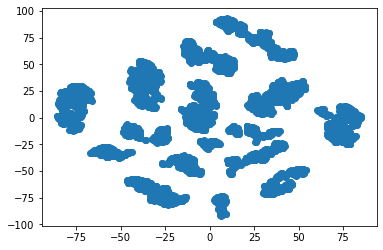

In [38]:
from sklearn.manifold import TSNE
protein_vectors_tsne = TSNE(n_components=2).fit_transform(protein_vectors.to('cpu').numpy())
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111)
ax.scatter(protein_vectors_tsne[:,0], protein_vectors_tsne[:,1])
plt.show()

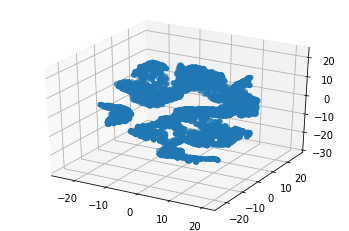

In [39]:
from sklearn.manifold import TSNE
protein_vectors_tsne = TSNE(n_components=3).fit_transform(protein_vectors.to('cpu').numpy())
import matplotlib.pyplot as plt
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(protein_vectors_tsne[:,0], protein_vectors_tsne[:,1], protein_vectors_tsne[:,2])
plt.show()